`conda activate imgpro`

# 1. Imports and Configuration

In [ ]:
import sys
import os
import glob
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple, Optional, Literal, Dict, Any, List
from dataclasses import dataclass
from scipy import stats
from utils import pretty_plot

%matplotlib widget

# Configure matplotlib
font = {'family': 'Arial', 'weight': 'normal', 'size': 20}
matplotlib.rc('font', **font)

# ============================================================================
# CONFIGURATION - Edit these parameters
# ============================================================================

@dataclass
class Config:
    """Configuration for coding direction analysis."""
    # Data path
    data_path: str = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
    # data_path: str = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004'
    # data_path: str = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005'
    
    # Timing parameters
    fps: float = 1 / 0.533
    bin_factor: int = 4
    
    # Epoch windows (frame indices) for date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
    baseline_window: Tuple[int, int] = (10, 60)
    pre_window: Tuple[int, int] = (82, 123)
    post_window: Tuple[int, int] = (141, 181)
    encounter_frame: int = 130
    good_frames: Optional[List[int]] = range(0,600) # List of good frames to use, or None to use all frames in the epoch windows

    # # Epoch windows (frame indices) for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004
    # baseline_window: Tuple[int, int] = (500, 540)
    # pre_window: Tuple[int, int] = (564, 584)
    # post_window: Tuple[int, int] = (678, 705)
    # good_frames: Optional[List[int]] = range(baseline_window[0], 1100) 

    # # Epoch windows (frame indices) for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005
    # baseline_window: Tuple[int, int] = (0, 60)
    # pre_window: Tuple[int, int] = (108, 161)
    # post_window: Tuple[int, int] = (171, 213)
    # good_frames: Optional[List[int]] = range(0, 444) 
    
    # Preprocessing
    # rfp_thresh: float = 50  # RFP intensity threshold for mask (for date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001)
    rfp_thresh: float = 20  # RFP intensity threshold for mask (for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004)
    keep_width: Tuple[int, int] = None #(25, 228)  # X-range to keep
    zero_prob_thresh: float = 5 # in percent, masks voxels that are zero more than this percent of timepoints. registered data has regions of the worm cut off that are inside the mask and vary across z-planes and recording

    # Analysis options
    top_n_voxels: Optional[int] = None  # None = use all voxels, int = use top N most variable
    preprocess_method: Literal['raw', 'zscore', 'center'] = 'raw'  # 'raw' = R/R0, 'zscore', 'center' = mean-centered

config = Config()
print(f"Data path: {config.data_path}")
print(f"Preprocessing: {config.preprocess_method}")
print(f"Top N voxels: {config.top_n_voxels or 'all'}")

Data path: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
Preprocessing: raw
Top N voxels: all


# 2. Function Definitions

In [145]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_data(config: Config) -> Dict[str, np.ndarray]:
    """
    Load all required data files.
    
    Returns:
        Dictionary with keys: 'g5', 'mask', 'rfp_mean', 'roi', 'z_with_roi'
    """
    pth = config.data_path
    
    # Load ROI
    roi = tifffile.imread(os.path.join(pth, 'roi.tif'))
    
    # Load normalized voxels (R/R0)
    g5 = np.load(os.path.join(pth, 'normalized_voxels.npy'))
    
    # Load and bin mask
    fixed_mask_fn = glob.glob(os.path.join(pth, 'fixed_mask_*.tif'))[0]
    mask = tifffile.imread(fixed_mask_fn)
    
    # Repeat mask to match g5 z-dimension
    mask = np.repeat(mask[np.newaxis, :, :], g5.shape[1], axis=0)
    
    # Load RFP mean
    rfp_mean = np.load(os.path.join(pth, 'rfp_mean.npy'))
        
    # Find z-slices with ROI labels
    z_with_roi = np.where(np.sum(roi, axis=(1, 2)) > 0)[0]
    
    print(f"Loaded data shapes:")
    print(f"  ROI: {roi.shape}")
    print(f"  g5 (R/R0): {g5.shape}")
    print(f"  mask: {mask.shape}")
    print(f"  rfp_mean: {rfp_mean.shape}")
    print(f"  Z slices with ROI: {z_with_roi}")
    
    return {
        'g5': g5,
        'mask': mask,
        'rfp_mean': rfp_mean,
        'roi': roi,
        'z_with_roi': z_with_roi
    }


def preprocess_data(data: Dict[str, np.ndarray], config: Config) -> Dict[str, np.ndarray]:
    """
    Preprocess data: subset to good_frames, subsample z-slices, apply mask, trim width.
    
    Returns:
        Dictionary with preprocessed 'g5', 'mask_updated', 'z_with_roi', 'adjusted_windows', 'original_frame_indices'
    """
    g5 = data['g5'].copy()
    mask = data['mask'].copy()
    rfp_mean = data['rfp_mean'].copy()
    z_with_roi = data['z_with_roi']
    
    # Bin spatial dimensions
    g5 = bin_spatial_dimensions(g5, config.bin_factor)
    mask = bin_spatial_dimensions(mask, config.bin_factor)
    rfp_mean = bin_spatial_dimensions(rfp_mean, config.bin_factor)
    
    # Subset to good_frames if specified
    if config.good_frames is not None:
        good_frames = np.array(list(config.good_frames))  # Convert range/list to array
        original_n_frames = g5.shape[0]
        g5 = g5[good_frames, :, :, :]
        print(f"  Subset to {len(good_frames)} good frames (from {original_n_frames} total)")
        print(f"    Original frame range: {good_frames[0]} to {good_frames[-1]}")
        original_frame_indices = good_frames
        # Compute adjusted epoch windows (remap to new indices)
        # Create a mapping from original frame indices to new indices
        frame_to_new_idx = {orig_idx: new_idx for new_idx, orig_idx in enumerate(good_frames)}
        
        def remap_window(window: Tuple[int, int]) -> Tuple[int, int]:
            """Remap epoch window to new frame indices."""
            start, end = window
            # Find the first good frame >= start
            new_start = None
            for orig_idx in range(start, end):
                if orig_idx in frame_to_new_idx:
                    new_start = frame_to_new_idx[orig_idx]
                    break
            # Find the last good frame < end
            new_end = None
            for orig_idx in range(end - 1, start - 1, -1):
                if orig_idx in frame_to_new_idx:
                    new_end = frame_to_new_idx[orig_idx] + 1  # +1 because end is exclusive
                    break
            if new_start is None or new_end is None:
                raise ValueError(f"Epoch window {window} has no frames in good_frames range")
            return (new_start, new_end)
        
        adjusted_windows = {
            'baseline': remap_window(config.baseline_window),
            'pre': remap_window(config.pre_window),
            'post': remap_window(config.post_window)
        }
        print(f"  Adjusted epoch windows (new indices):")
        print(f"    Baseline: {config.baseline_window} -> {adjusted_windows['baseline']}")
        print(f"    Pre:      {config.pre_window} -> {adjusted_windows['pre']}")
        print(f"    Post:     {config.post_window} -> {adjusted_windows['post']}")
    else:
        good_frames = np.arange(g5.shape[0])
        adjusted_windows = {
            'baseline': config.baseline_window,
            'pre': config.pre_window,
            'post': config.post_window
        }
        print(f"  Using all {g5.shape[0]} frames (good_frames not specified)")
    
    # Subsample z-slices to those with ROI
    g5 = g5[:, z_with_roi, :, :]
    mask = mask[z_with_roi, :, :]
    rfp_mean = rfp_mean[z_with_roi, :, :]
    
    # Update mask based on RFP threshold
    mask_updated = mask.copy()
    mask_updated[rfp_mean < config.rfp_thresh] = 0

    # Update mask based on zero probability threshold
    # Remove voxels that are zero more than zero_prob_threshold% of the time
    # First apply mask to g5 before computing zero probability (so we only count zeros within the mask)
    g5_masked = g5 * mask[np.newaxis, :, :, :]
    zero_mask = (g5_masked == 0)  # Shape: (T, Z, H, W)
    zero_prob = np.mean(zero_mask, axis=0)  # Shape: (Z, H, W), fraction (0-1)
    # Set zero probability to NaN for voxels outside the worm mask
    zero_prob[mask == 0] = np.nan
    
    # Create a mask for voxels that are good (zero less than threshold fraction of time)
    good_voxel_mask = zero_prob < (config.zero_prob_thresh / 100)  # Convert threshold from percent to fraction
    
    # Update the mask to exclude bad voxels (make sure no type errors)
    mask_updated = np.logical_and(mask_updated, good_voxel_mask)
    
    print(f"  Removed {np.sum(~good_voxel_mask & (mask > 0))} voxels with >{config.zero_prob_thresh}% zeros")
    # Apply mask to g5
    g5 = g5 * mask_updated[np.newaxis, :, :]
    
    # Trim width
    if config.keep_width is not None:
        g5 = g5[:, :, :, config.keep_width[0]:config.keep_width[1]]
        mask_updated = mask_updated[:, :, config.keep_width[0]:config.keep_width[1]]
    
    print(f"\nPreprocessed data:")
    print(f"  g5: {g5.shape}")
    print(f"  mask_updated: {mask_updated.shape}")
    print(f"  Number of voxels in mask: {np.sum(mask_updated > 0)}")
    
    return {
        'g5': g5,
        'mask_updated': mask_updated,
        'z_with_roi': z_with_roi,
        'adjusted_windows': adjusted_windows,
        'original_frame_indices': good_frames
    }

def bin_spatial_dimensions(data: np.ndarray, bin_factor: int) -> np.ndarray:
    """
    Bin the spatial dimensions of a 4D array (time, z, h, w), a 3D array (z, h, w), or a 2D array (h, w)
    
    Args:
        data: numpy array of shape (time, z, h, w), (z, h, w), or (h, w)
        bin_factor: Factor by which to bin the spatial dimensions
    
    Returns:
        Binned numpy array
    """
    if data.ndim == 4:
        t, z, h, w = data.shape
        h_binned = h // bin_factor
        w_binned = w // bin_factor
        return data[:, :, :h_binned*bin_factor, :w_binned*bin_factor].reshape(
            t, z, h_binned, bin_factor, w_binned, bin_factor
        ).mean(axis=(3, 5))
    elif data.ndim == 3:
        z, h, w = data.shape
        h_binned = h // bin_factor
        w_binned = w // bin_factor
        return data[:, :h_binned*bin_factor, :w_binned*bin_factor].reshape(
            z, h_binned, bin_factor, w_binned, bin_factor
        ).mean(axis=(2, 4))
    elif data.ndim == 2:
        h, w = data.shape
        h_binned = h // bin_factor
        w_binned = w // bin_factor
        return data[:h_binned*bin_factor, :w_binned*bin_factor].reshape(
            h_binned, bin_factor, w_binned, bin_factor
        ).mean(axis=(1, 3))
    else:
        raise ValueError(f"Unsupported data shape: {data.shape}")

# ============================================================================
# VOXEL SELECTION AND PREPROCESSING FUNCTIONS
# ============================================================================

def flatten_and_mask(g5: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Flatten 4D g5 to 2D (time, voxels) and apply mask.
    
    Args:
        g5: 4D array (time, z, h, w)
        mask: 3D array (z, h, w)
    
    Returns:
        g5_flat: 2D array (time, n_valid_voxels)
        mask_flat: 1D boolean array indicating valid voxel positions
    """
    g5_flat = g5.reshape(g5.shape[0], -1)
    mask_flat = mask.reshape(-1) > 0
    g5_masked = g5_flat[:, mask_flat]
    return g5_masked, mask_flat


def select_top_n_voxels(g5_flat: np.ndarray, n: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Select top N most variable voxels.
    
    Args:
        g5_flat: 2D array (time, voxels)
        n: Number of top voxels to keep (None = keep all)
    
    Returns:
        g5_selected: 2D array with selected voxels
        sort_indices: Indices of selected voxels (sorted by variance, descending)
    """
    voxel_vars = np.var(g5_flat, axis=0)
    sort_indices = np.argsort(voxel_vars)[::-1]  # Descending
    
    if n is not None and n < len(sort_indices):
        sort_indices = sort_indices[:n]
        print(f"  Selected top {n} most variable voxels")
    else:
        print(f"  Using all {len(sort_indices)} voxels")
    
    return g5_flat[:, sort_indices], sort_indices


def apply_preprocessing(g5: np.ndarray, method: str = 'raw') -> np.ndarray:
    """
    Apply preprocessing to data.
    
    Args:
        g5: 2D array (time, voxels)
        method: 'raw' (R/R0), 'zscore', or 'center' (mean-centered)
    
    Returns:
        Preprocessed data
    """
    if method == 'raw':
        print(f"  Preprocessing: raw (R/R0)")
        return g5
    elif method == 'zscore':
        print(f"  Preprocessing: z-score")
        # Z-score each voxel independently
        mean = np.mean(g5, axis=0, keepdims=True)
        std = np.std(g5, axis=0, keepdims=True)
        std[std == 0] = 1  # Avoid division by zero
        return (g5 - mean) / std
    elif method == 'center':
        print(f"  Preprocessing: mean-centered")
        mean = np.mean(g5, axis=0, keepdims=True)
        return g5 - mean
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

# ============================================================================
# VOXEL INDEX MAPPING FUNCTIONS
# ============================================================================

def preprocessed_idx_to_spatial(
    preprocessed_indices: np.ndarray,
    selected_indices: np.ndarray,
    mask_flat: np.ndarray,
    spatial_shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Map preprocessed voxel indices to original 3D spatial coordinates.
    
    This function converts column indices from g5_preprocessed back to their
    original (z, h, w) coordinates in the binned 4D data.
    
    Args:
        preprocessed_indices: Array of voxel indices in g5_preprocessed (axis 1 indices)
        selected_indices: Indices from select_top_n_voxels indicating which masked 
                         voxels were selected (maps preprocessed -> masked)
        mask_flat: 1D boolean array from flatten_and_mask indicating valid positions
                  in the flattened spatial volume (maps masked -> flattened)
        spatial_shape: Tuple (z, h, w) of the binned spatial dimensions
    
    Returns:
        coords: Array of shape (N, 3) with (z, h, w) coordinates for each index
    
    Example:
        >>> # Get coordinates for top 10 most active voxels
        >>> top_10_idx = np.arange(10)
        >>> coords = preprocessed_idx_to_spatial(top_10_idx, selected_indices, 
        ...                                       mask_flat, spatial_shape)
        >>> print(coords)  # [[z0, h0, w0], [z1, h1, w1], ...]
    """
    # Step 1: Map from preprocessed indices to masked indices
    masked_indices = selected_indices[preprocessed_indices]
    
    # Step 2: Map from masked indices to flat indices in full spatial volume
    # Get all flat indices that are True in mask_flat
    flat_indices = np.where(mask_flat)[0]
    full_flat_indices = flat_indices[masked_indices]
    
    # Step 3: Convert flat indices to 3D coordinates
    z, h, w = spatial_shape
    coords = np.zeros((len(full_flat_indices), 3), dtype=int)
    coords[:, 0] = full_flat_indices // (h * w)  # z coordinate
    coords[:, 1] = (full_flat_indices % (h * w)) // w  # h coordinate
    coords[:, 2] = full_flat_indices % w  # w coordinate
    
    return coords


def plot_voxel_spatial_map(
    voxel_data: np.ndarray,
    voxel_indices: np.ndarray,
    selected_indices: np.ndarray,
    mask_flat: np.ndarray,
    mask_3d: np.ndarray,
    spatial_shape: Tuple[int, int, int],
    z_with_roi: Optional[np.ndarray] = None,
    cmap: str = 'viridis',
    figsize_per_z: Tuple[float, float] = (5, 4),
    vmin=0,
    vmax=6,
    nrows=3,
    ncols=4,
    mask_color='black',
    norm_cmap=None,
    encounter_time=None,
    num_cbar_ticks=6
) -> plt.Figure:
    """
    Plot spatial map of selected voxels across z-planes.
    
    Creates a multi-panel figure showing the spatial distribution of voxel values
    across all z-planes that contain the selected voxels. Each panel shows one z-plane
    with voxels colored by their data values.
    
    Args:
        voxel_data: 1D array of values for each voxel (length = number of voxels)
                   Can be a single timepoint, mean, variance, or any voxel metric
        voxel_indices: 1D array of voxel indices in g5_preprocessed to plot
        selected_indices: Indices from select_top_n_voxels (maps preprocessed -> masked)
        mask_flat: 1D boolean array from flatten_and_mask (maps masked -> flattened)
        spatial_shape: Tuple (z, h, w) of the binned spatial dimensions
        z_with_roi: Optional array of original z-indices (for labeling). If None, uses 0-indexed
        cmap: Colormap for the voxel values
        figsize_per_z: Figure size (width, height) per z-plane panel
        title: Overall figure title
    
    Returns:
        Matplotlib figure object
    
    Example:
        >>> # Plot mean activity of top 100 voxels
        >>> top_100_idx = np.arange(100)
        >>> mean_activity = np.mean(g5_preprocessed[:, top_100_idx], axis=0)
        >>> fig = plot_voxel_spatial_map(mean_activity, top_100_idx, 
        ...                              selected_indices, mask_flat, spatial_shape,
        ...                              z_with_roi, title="Mean Activity")
    """
    # Get spatial coordinates for the voxel indices
    coords = preprocessed_idx_to_spatial(voxel_indices, selected_indices, 
                                        mask_flat, spatial_shape)
    
    # Ensure voxel_data is 1D and matches voxel_indices length
    if voxel_data.ndim > 1:
        if voxel_data.shape[0] == 1:
            voxel_data = voxel_data.squeeze()
        else:
            raise ValueError(f"voxel_data must be 1D or shape (1, N), got {voxel_data.shape}")
    
    if len(voxel_data) != len(voxel_indices):
        raise ValueError(f"voxel_data length ({len(voxel_data)}) must match "
                        f"voxel_indices length ({len(voxel_indices)})")
    
    # Find unique z-planes that contain the selected voxels
    z_planes = np.unique(coords[:, 0])
    n_planes = len(z_planes)
    
    
    fig = plt.figure(
    figsize=(figsize_per_z[0] * n_planes, figsize_per_z[1])
    )

    gs = fig.add_gridspec(
        nrows, ncols,
        wspace=0.001,
        hspace=0.001
    )

    axs = np.array([
        fig.add_subplot(gs[i // ncols, i % ncols])
        for i in range(nrows * ncols)
    ])

    z, h, w = spatial_shape
    
    # Plot each z-plane
    for i, z_plane in enumerate(z_planes):
        ax = axs[i]
        
        # Create empty spatial map for this z-plane
        spatial_map = np.full((h, w), np.nan)
        
        # Fill in values for voxels in this z-plane
        z_mask = coords[:, 0] == z_plane
        z_coords = coords[z_mask]
        z_data = voxel_data[z_mask]
        
        spatial_map[z_coords[:, 1], z_coords[:, 2]] = z_data
        
        
        # Plot
        if norm_cmap is not None:
            im = ax.imshow(spatial_map, cmap=cmap, norm=norm_cmap)
        else:
            im = ax.imshow(spatial_map, cmap=cmap, vmin=vmin, vmax=vmax)
        
        # plot mask contours (levels=[0.5] draws boundary between 0 and non-zero)
        ax.contour(mask_3d[z_plane].astype(float), colors=mask_color, linewidths=0.5, levels=[0.5])
        
        ax.set_xlim(20,w)
        
        # # Label with original z-index if available
        # if z_with_roi is not None:
        #     ax.set_title(f'z{z_with_roi[z_plane]}', fontsize=12)
        # else:
        #     ax.set_title(f'z{z_plane}', fontsize=12)
        
        # # Add colorbar
        # if i==0:
        #     cbar = fig.colorbar(im, ax=ax, orientation='horizontal', 
        #                     fraction=0.046, pad=0.04)
        #     cbar.ax.tick_params(labelsize=12)
            
        #     # show specific cbar ticks
        #     if encounter_time is not None and norm_cmap is not None:
        #         cbar.set_ticks([np.round(vmin), np.round(encounter_time), np.round(vmax)])
        #     elif norm_cmap is not None:
        #         cbar.set_ticks([np.round(vmin), np.round(vmax//3), np.round(vmax)])
        #     elif encounter_time is not None:
        #         cbar.set_ticks([np.round(vmin), np.round(encounter_time), np.round(vmax)])
        #     else:
        #         cbar.set_ticks([np.round(vmin), np.round(vmax//2), np.round(vmax)])
        
        ax.axis('off')

        
    # hide any subplots that weren't used
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        
    # make sure spacing between axes is minimal
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01,
                    wspace=0.005, hspace=0.005)

        
    # add colorbar to the bottom of the plot
    cbar_ax = fig.add_axes([0.3, 0.025, 0.4, 0.03])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', 
                        fraction=0.03, pad=0.005)
    # change label font size
    cbar.ax.tick_params(labelsize=14)
    
    cbar_ticks = np.round(np.linspace(vmin, vmax, num_cbar_ticks))
    cbar.set_ticks(cbar_ticks)
    # draw arrow pointing to encounter time
    if encounter_time is not None:
        cbar.ax.annotate('', xy=(encounter_time, 0), xytext=(encounter_time, 1),
                        arrowprops=dict(facecolor='magenta', shrink=0.5))
    

    return fig


# ============================================================================
    # PLOTTING FUNCTIONS
# ============================================================================

def plot_representative_slices(g5: np.ndarray, z_with_roi: np.ndarray, mask: np.ndarray,
                                frame: int, title: str = "Activity"):
    """Plot representative z-slices for a given frame."""
    n_z = g5.shape[1]
    slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    # slice_indices = np.arange(0,n_z, 2)
    
    fig, axs = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 4), 
                            constrained_layout=True)
    if len(slice_indices) == 1:
        axs = [axs]
    
    for i, slice_idx in enumerate(slice_indices):
        ax = axs[i]
        im = ax.imshow(g5[frame, slice_idx], cmap='viridis')
        # plot mask contours (levels=[0.5] draws boundary between 0 and non-zero)
        ax.contour(mask[slice_idx].astype(float), colors='white', linewidths=0.5, levels=[0.5])
        ax.set_title(f'z{z_with_roi[slice_idx]}')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=16)
        # for cbar, only show ticks at min and max
        cbar.set_ticks([g5[frame, slice_idx].min(), g5[frame, slice_idx].max()])
        ax.axis('off')
    
    fig.suptitle(f'{title} (frame {frame})', y=0.95)
    return fig


def plot_voxel_heatmap(g5_flat: np.ndarray, fps: float, time_window: Optional[Tuple[int, int]] = None,
                       max_voxels: int = 50000, vmin_pct: float = 1.0, vmax_pct: float = 99.0):
    """Plot heatmap of voxel activity over time."""
    # Optionally subset time window
    if time_window is not None:
        g5_subset = g5_flat[time_window[0]:time_window[1]]
        time_offset = time_window[0]
    else:
        g5_subset = g5_flat
        time_offset = 0
    
    # Sort by variance and limit voxels
    voxel_vars = np.var(g5_subset, axis=0)
    sort_idx = np.argsort(voxel_vars)[::-1]
    n_show = min(max_voxels, g5_subset.shape[1])
    g5_sorted = g5_subset[:, sort_idx[:n_show]]
    
    # get vmin and vmax by percentile
    vmin = np.percentile(g5_sorted, vmin_pct)
    vmax = np.percentile(g5_sorted, vmax_pct)
    
    time = (np.arange(g5_subset.shape[0]) + time_offset) / fps
    
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(g5_sorted.T, aspect='auto', cmap='viridis', 
                   extent=[time[0], time[-1], 0, n_show],
                   vmin=vmin, vmax=vmax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voxel (sorted by variance)')
    ax.set_title(f'Voxel Activity Heatmap (top {n_show} voxels)')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Activity')
    return fig


def causal_smooth(data: np.ndarray, sigma: float, truncate: float = 4.0) -> np.ndarray:
    """
    Apply causal (one-sided) Gaussian smoothing along time axis.
    
    Args:
        data: 2D array (time, voxels)
        sigma: Standard deviation of Gaussian kernel (in frames)
        truncate: Number of standard deviations to truncate kernel
    
    Returns:
        Smoothed data
    """
    from scipy.ndimage import convolve1d
    
    # Create causal Gaussian kernel
    kernel_size = int(truncate * sigma) + 1
    x = np.arange(kernel_size)
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / kernel.sum()  # Normalize
    
    # Apply along time axis (axis 0), with 'mirror' mode for edges
    smoothed = convolve1d(data, kernel, axis=0, mode='nearest')
    
    return smoothed


# ============================================================================
# RESPONSE STATISTICS AND LATENCY DETECTION
# ============================================================================

@dataclass
class ResponseStats:
    """Container for response statistics results."""
    # Per-voxel epoch means
    mean_baseline: np.ndarray
    mean_pre: np.ndarray
    mean_post: np.ndarray
    
    # Per-voxel epoch variances
    var_baseline: np.ndarray
    var_pre: np.ndarray
    var_post: np.ndarray
    
    # Significance detection
    significant_mask: np.ndarray  # (time, voxels) boolean
    voxel_response_prob: np.ndarray  # Fraction of time each voxel is significant
    
    # Latency (frame index of first sustained response, NaN if no response)
    latency: np.ndarray
    
    # Whether each voxel shows a significant response at all
    is_responsive: np.ndarray  # boolean


def compute_response_statistics(
    g5: np.ndarray,
    baseline_window: Tuple[int, int],
    pre_window: Optional[Tuple[int, int]] = None,
    post_window: Optional[Tuple[int, int]] = None,
    n_std: float = 3.0,
    min_consecutive: int = 3,
    smooth_sigma: Optional[float] = None,
    detection_start: Optional[int] = None,
    min_response_prob: float = 0.05
) -> ResponseStats:
    """
    Compute response statistics for preprocessed voxel data.
    
    Uses a statistically rigorous approach to detect response onset:
    1. Computes baseline mean and std for each voxel
    2. Optionally smooths data to reduce high-frequency noise
    3. Detects significant activation as exceeding baseline by n_std
    4. Requires min_consecutive frames of sustained activation for latency
    
    Args:
        g5: 2D array (time, voxels) of preprocessed activity
        baseline_window: Tuple (start, end) frame indices for baseline epoch
        pre_window: Optional tuple (start, end) for pre-stimulus epoch
        post_window: Optional tuple (start, end) for post-stimulus epoch
        n_std: Number of standard deviations above baseline mean for significance
        min_consecutive: Minimum consecutive frames above threshold for latency detection.
                        This prevents single-frame noise spikes from being detected as responses.
        smooth_sigma: Optional Gaussian smoothing sigma (frames) before threshold detection.
                     If None, no additional smoothing is applied.
        detection_start: Frame index to start latency detection from. If None, uses
                        end of baseline window. Useful if you want to detect responses
                        only after a specific stimulus onset.
        min_response_prob: Minimum fraction of time a voxel must be significant
                          to be considered responsive (default 0.05 = 5%)
    
    Returns:
        ResponseStats dataclass with all computed statistics
    
    Example:
        >>> stats = compute_response_statistics(
        ...     g5_preprocessed,
        ...     baseline_window=(10, 60),
        ...     pre_window=(82, 123),
        ...     post_window=(141, 181),
        ...     n_std=3.0,
        ...     min_consecutive=3,
        ...     smooth_sigma=2.0
        ... )
        >>> print(f"Responsive voxels: {np.sum(stats.is_responsive)}")
        >>> print(f"Median latency: {np.nanmedian(stats.latency):.1f} frames")
    """
    n_time, n_voxels = g5.shape
    
    # Compute baseline statistics
    baseline_data = g5[baseline_window[0]:baseline_window[1]]
    mean_baseline = np.mean(baseline_data, axis=0)
    var_baseline = np.var(baseline_data, axis=0, ddof=1)  # Use ddof=1 for unbiased estimate
    std_baseline = np.sqrt(var_baseline)
    
    # Handle zero-variance voxels (set std to inf to prevent false positives)
    std_baseline[std_baseline == 0] = np.inf
    
    # Compute epoch means and variances
    if pre_window is not None:
        mean_pre = np.mean(g5[pre_window[0]:pre_window[1]], axis=0)
        var_pre = np.var(g5[pre_window[0]:pre_window[1]], axis=0, ddof=1)
    else:
        mean_pre = np.full(n_voxels, np.nan)
        var_pre = np.full(n_voxels, np.nan)
        
    if post_window is not None:
        mean_post = np.mean(g5[post_window[0]:post_window[1]], axis=0)
        var_post = np.var(g5[post_window[0]:post_window[1]], axis=0, ddof=1)
    else:
        mean_post = np.full(n_voxels, np.nan)
        var_post = np.full(n_voxels, np.nan)
    
    # Optionally smooth data for threshold detection
    if smooth_sigma is not None and smooth_sigma > 0:
        g5_for_detection = causal_smooth(g5, sigma=smooth_sigma)
    else:
        g5_for_detection = g5
    
    # Compute threshold for each voxel
    threshold = mean_baseline + n_std * std_baseline
    
    # Compute significant mask (vectorized)
    significant_mask = g5_for_detection > threshold[np.newaxis, :]
    
    # Compute response probability per voxel
    voxel_response_prob = np.mean(significant_mask, axis=0)
    
    # Detect latency using sustained activation criterion
    if detection_start is None:
        detection_start = baseline_window[1]
    
    latency = _detect_sustained_onset(
        significant_mask, 
        min_consecutive=min_consecutive,
        start_frame=detection_start
    )
    
    # Determine if voxel is responsive (has latency and sufficient response probability)
    is_responsive = ~np.isnan(latency) & (voxel_response_prob >= min_response_prob)
    
    return ResponseStats(
        mean_baseline=mean_baseline,
        mean_pre=mean_pre,
        mean_post=mean_post,
        var_baseline=var_baseline,
        var_pre=var_pre,
        var_post=var_post,
        significant_mask=significant_mask,
        voxel_response_prob=voxel_response_prob,
        latency=latency,
        is_responsive=is_responsive
    )


def _detect_sustained_onset(
    significant_mask: np.ndarray,
    min_consecutive: int,
    start_frame: int = 0
) -> np.ndarray:
    """
    Detect the first frame of sustained activation for each voxel.
    
    A sustained response is defined as min_consecutive consecutive frames
    where the voxel is above threshold.
    
    Args:
        significant_mask: Boolean array (time, voxels) indicating threshold crossings
        min_consecutive: Minimum number of consecutive True values required
        start_frame: Frame index to start detection from
    
    Returns:
        latency: Array of frame indices (NaN if no sustained response detected)
    """
    n_time, n_voxels = significant_mask.shape
    latency = np.full(n_voxels, np.nan)
    
    # Subset to detection window
    mask_subset = significant_mask[start_frame:]
    n_frames = mask_subset.shape[0]
    
    if min_consecutive <= 1:
        # Simple case: just find first True
        for v in range(n_voxels):
            indices = np.where(mask_subset[:, v])[0]
            if indices.size > 0:
                latency[v] = indices[0] + start_frame
    else:
        # Need to find min_consecutive consecutive Trues
        # Use convolution to count consecutive runs efficiently
        kernel = np.ones(min_consecutive)
        
        for v in range(n_voxels):
            trace = mask_subset[:, v].astype(float)
            # Convolve with kernel - value equals min_consecutive means we have a run
            conv = np.convolve(trace, kernel, mode='valid')
            sustained_indices = np.where(conv >= min_consecutive)[0]
            
            if sustained_indices.size > 0:
                # The convolution gives us the END of the run, so the start is:
                # sustained_idx corresponds to where the run ends at position sustained_idx + min_consecutive - 1
                # So the run STARTS at sustained_idx
                latency[v] = sustained_indices[0] + start_frame
    
    return latency


def response_statistics(g5: np.ndarray, config, n_std: float = 5.0, 
                       min_consecutive: int = 3, smooth_sigma: float = 2.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Legacy wrapper for compute_response_statistics.
    
    Compute statistics for the preprocessed g5 data:
    1. For each voxel, compute when activity is statistically different from baseline
    2. Calculate the probability that a voxel is significantly active
    3. Calculate the latency of the response using sustained activation criterion
    
    Args:
        g5: 2D array (time, voxels) of preprocessed activity
        config: Config object with baseline_window, pre_window, post_window
        n_std: Number of standard deviations for significance threshold
        min_consecutive: Minimum consecutive frames above threshold for latency
        smooth_sigma: Gaussian smoothing sigma before detection (frames)
    
    Returns:
        significant_mask: Boolean array (time, voxels)
        voxel_probabilities: 1D array of response probabilities per voxel
        latency: 1D array of latency values (frames) per voxel
    """
    stats = compute_response_statistics(
        g5=g5,
        baseline_window=config.baseline_window,
        pre_window=config.pre_window,
        post_window=config.post_window,
        n_std=n_std,
        min_consecutive=min_consecutive,
        smooth_sigma=smooth_sigma,
        detection_start=config.baseline_window[1]
    )
    
    return stats.significant_mask, stats.voxel_response_prob, stats.latency


# 3. Load and Preprocess Data

In [3]:
# Load raw data
raw_data = load_data(config)

# # Preprocess (apply mask, subset z-slices, trim width, subset to good_frames)
processed = preprocess_data(raw_data, config)

# Store for later use
g5_4d = processed['g5']  # 4D: (time, z, h, w)
mask_3d = processed['mask_updated']  # 3D: (z, h, w)
z_with_roi = processed['z_with_roi']
adjusted_windows = processed['adjusted_windows']  # Epoch windows remapped to new frame indices
original_frame_indices = processed['original_frame_indices']  # Original frame indices for reference


print(f"\nData loaded and preprocessed successfully.")
print(f"\nAdjusted epoch windows (use these for analysis):")
print(f"  baseline_window: {adjusted_windows['baseline']}")
print(f"  pre_window: {adjusted_windows['pre']}")
print(f"  post_window: {adjusted_windows['post']}")

Loaded data shapes:
  ROI: (39, 200, 500)
  g5 (R/R0): (1200, 39, 200, 500)
  mask: (39, 200, 500)
  rfp_mean: (39, 200, 500)
  Z slices with ROI: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
  Subset to 600 good frames (from 1200 total)
    Original frame range: 0 to 599
  Adjusted epoch windows (new indices):
    Baseline: (10, 60) -> (10, 60)
    Pre:      (82, 123) -> (82, 123)
    Post:     (141, 181) -> (141, 181)
  Removed 8939 voxels with >5% zeros

Preprocessed data:
  g5: (600, 19, 50, 125)
  mask_updated: (19, 50, 125)
  Number of voxels in mask: 52060

Data loaded and preprocessed successfully.

Adjusted epoch windows (use these for analysis):
  baseline_window: (10, 60)
  pre_window: (82, 123)
  post_window: (141, 181)


# 4. Flatten, Select Voxels, and Preprocess

In [4]:
# Flatten 4D data to 2D and apply mask
g5_flat_all, mask_flat = flatten_and_mask(g5_4d, mask_3d)
print(f"Flattened data: {g5_flat_all.shape} (time x voxels)")

# Select top N most variable voxels (or all if None)
g5_selected, selected_indices = select_top_n_voxels(g5_flat_all, config.top_n_voxels)
print(f"Selected data: {g5_selected.shape}")

# Apply preprocessing (raw/zscore/center)
g5_preprocessed = apply_preprocessing(g5_selected, config.preprocess_method)

# Store spatial shape for later (for reshaping coding directions)
spatial_shape = (g5_4d.shape[1], g5_4d.shape[2], g5_4d.shape[3])  # (z, h, w)
print(f"\nSpatial shape: {spatial_shape}")

Flattened data: (600, 52060) (time x voxels)
  Using all 52060 voxels
Selected data: (600, 52060)
  Preprocessing: raw (R/R0)

Spatial shape: (19, 50, 125)


# 5. Visualize Raw Data

Showing frame 178 (original frame 178)


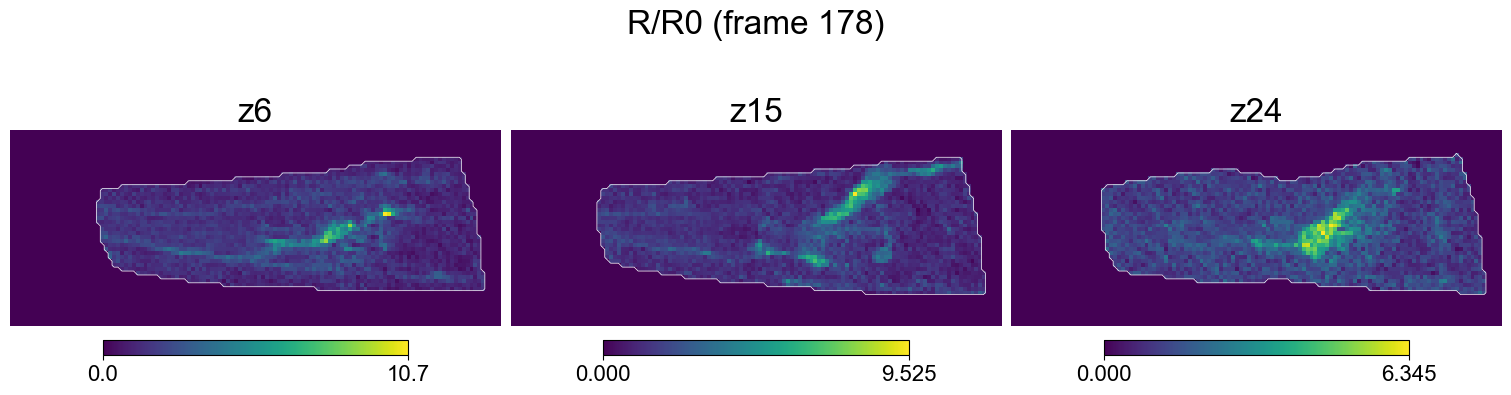

In [5]:
%matplotlib inline
plt.close('all')

# Plot representative z-slices at a chosen frame
# Use a frame index relative to the subsetted data (0 to T-1 where T = len(good_frames))
frame_to_show = 178  # Relative to good_frames start
print(f"Showing frame {frame_to_show} (original frame {original_frame_indices[frame_to_show]})")

fig1 = plot_representative_slices(g5_4d, z_with_roi, mask_3d, frame=frame_to_show, title="R/R0")
plt.show()

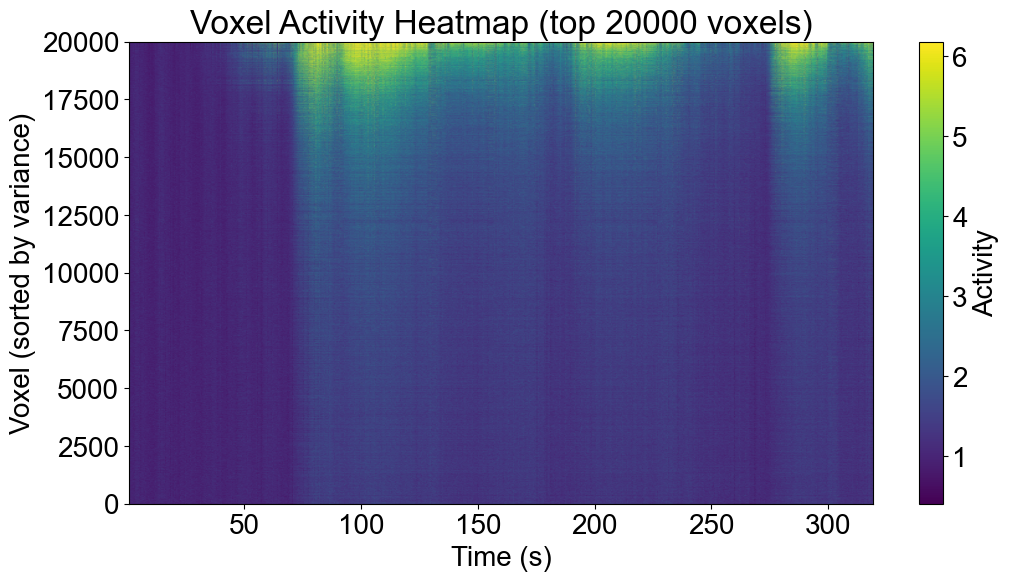

In [6]:
# Plot voxel heatmap over time (for selected voxels)
%matplotlib inline
fig2 = plot_voxel_heatmap(g5_preprocessed, config.fps, time_window=(1,600), max_voxels=20000, vmax_pct=99.5)
plt.show()

In [7]:
%matplotlib qt

# Sort by variance and limit voxels
max_voxels = 10
# voxel_metric = np.var(g5_preprocessed, axis=0)
voxel_metric = np.mean(g5_preprocessed, axis=0)
sort_idx = np.argsort(voxel_metric)[::-1]
n_show = min(max_voxels, g5_preprocessed.shape[1])
g5_sorted = g5_preprocessed[:, sort_idx[:n_show]]

smoothed = causal_smooth(g5_sorted, sigma=5.0, truncate=4.0)

plt.figure()
plt.plot(smoothed)
plt.show()

smoothed = causal_smooth(g5_sorted, sigma=2.0, truncate=20.0)

plt.figure()
plt.plot(smoothed)
plt.show()

# 6. Response Statistics and Latency Detection

In [63]:
# Compute response statistics using the robust method
# Key parameters:
#   n_std: Number of standard deviations above baseline for significance (default 3.0)
#   min_consecutive: Minimum consecutive frames above threshold for latency (default 3)
#   smooth_sigma: Gaussian smoothing sigma for noise reduction (default 2.0)

response_stats = compute_response_statistics(
    g5=g5_preprocessed,
    baseline_window=config.baseline_window,
    pre_window=config.pre_window,
    post_window=config.post_window,
    n_std=2.0,           # Significance threshold (std above baseline)
    min_consecutive=5,   # Require 3 consecutive frames for robust latency
    smooth_sigma=3.0,    # Smooth before detection to reduce noise
    detection_start=config.baseline_window[1],  # Start detecting after baseline
    min_response_prob=0.02  # Minimum 2% of time significant to be "responsive"
)

# Unpack commonly used variables
significant_mask = response_stats.significant_mask
voxel_probabilities = response_stats.voxel_response_prob
latency = response_stats.latency

# Print summary
print(f"Total voxels: {len(latency)}")
print(f"Responsive voxels: {np.sum(response_stats.is_responsive)}")
print(f"Voxels with detected latency: {np.sum(~np.isnan(latency))}")
print(f"Median latency: {np.nanmedian(latency):.1f} frames ({np.nanmedian(latency)/config.fps:.2f} s)")
print(f"Latency range: {np.nanmin(latency):.0f} - {np.nanmax(latency):.0f} frames")

Total voxels: 52060
Responsive voxels: 29776
Voxels with detected latency: 31455
Median latency: 146.0 frames (77.82 s)
Latency range: 60 - 595 frames


In [ ]:
fig, ax = pretty_plot()
ax.hist(latency / config.fps, bins=100)
ax.set_xlabel('Response latency from \n baseline start (seconds)')
ax.set_ylabel('# of voxels')
ax.set_xlim(0,150)
# plot vertical line at food encounter time, needs to be aligned with latency histogram which starts after baseline window
ax.axvline((config.encounter_frame - config.baseline_window[0]) / config.fps, color='k', linestyle='--')
plt.tight_layout()
plt.show()

The figure layout has changed to tight


In [71]:
# sort by latency
latency_sorted_idx = np.argsort(latency)
g5_sorted = g5_preprocessed[:, latency_sorted_idx]
significant_mask_sorted = significant_mask[:, latency_sorted_idx]

num2plot = 35000

plt.figure(figsize=(4.5,6))
plt.imshow(g5_sorted[:,:num2plot].T, aspect='auto', cmap='plasma', vmax=np.percentile(g5_sorted[:,:num2plot], 99))
cbar = plt.colorbar(label='R/R0')
plt.xlabel('Frame')
plt.ylabel('Voxel')
plt.tight_layout()
plt.show()

# heatmap of significant_mask
plt.figure(figsize=(4.5,6))
plt.imshow(significant_mask_sorted[:,:num2plot].T, aspect='auto', cmap='gray')
# plot small dot at latency
plt.scatter(latency[latency_sorted_idx[:num2plot]], np.arange(num2plot), color='red', s=1)
plt.xlabel('Frame')
plt.ylabel('Voxel')
plt.tight_layout()
plt.show()

In [ ]:
# plot spatial map of pre activation voxels, identified by the voxels with response latencies in the pre-stimulus window
pre_activation_voxels = np.where(latency < config.pre_window[1])[0]
# pre_activation_voxels = latency_sorted_idx[20000:30000]
mean_activity = np.mean(g5_preprocessed[config.pre_window[0]:config.pre_window[1], pre_activation_voxels], axis=0)

vmin = np.percentile(g5_preprocessed,1)
vmax = np.percentile(g5_preprocessed,99)

fig = plot_voxel_spatial_map(
    mean_activity, pre_activation_voxels, 
    selected_indices, mask_flat, mask_3d, spatial_shape,
    z_with_roi, 
    nrows=4,
    ncols=5,
    vmin=vmin,
    vmax=vmax
)
plt.show()

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


In [ ]:
# plot spatial map of post activation voxels. identified by the voxels with response latencies in the post-stimulus window
post_activation_voxels = np.where(latency > config.post_window[0])[0]
mean_activity = np.mean(g5_preprocessed[config.post_window[0]:config.post_window[1], post_activation_voxels], axis=0)
fig = plot_voxel_spatial_map(
    mean_activity, post_activation_voxels, 
    selected_indices, mask_flat, mask_3d, spatial_shape,
    z_with_roi, 
    nrows=4,
    ncols=5,
    vmin=vmin,
    vmax=vmax
)
plt.show()

In [ ]:
# plot spatial map of voxels without significant responses (latency is nan)
non_significant_voxels = np.where(np.isnan(latency))[0]
mean_activity = np.mean(g5_preprocessed[config.pre_window[0]:config.post_window[1], non_significant_voxels], axis=0)
fig = plot_voxel_spatial_map(
    mean_activity, non_significant_voxels, 
    selected_indices, mask_flat, mask_3d, spatial_shape,
    z_with_roi, 
    nrows=4,
    ncols=5,
    vmin=vmin,
    vmax=vmax
)
plt.show()

In [158]:
# plot latency spatial map
# voxels with a latency are plotted based on colormap
# voxels with latency==nan are plotted in black

latency_ = latency.copy()
latency_sec = latency_ / config.fps
encounter_time = (config.encounter_frame - config.baseline_window[0]) / config.fps

latency_sec[latency_sec > (encounter_time+20)] = np.nan


# vmin = np.nanmin(latency_sec)
# vmax = np.nanmax(latency_sec)
vmin = np.nanpercentile(latency_sec,0)
vmax = np.nanpercentile(latency_sec,100)


# norm_cmap = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
# gamma=0.6
gamma=1.0 # linear
# gamma = 1.4
norm_cmap = matplotlib.colors.PowerNorm(gamma=gamma,vmin=vmin, vmax=vmax)

fig = plot_voxel_spatial_map(
    latency_sec, np.arange(latency_sec.shape[0]),
    selected_indices, mask_flat, mask_3d, spatial_shape,
    z_with_roi,
    figsize_per_z=(10,10),
    nrows=4,
    ncols=5,
    vmin=vmin,
    vmax=vmax,
    cmap='Spectral',
    norm_cmap=norm_cmap,
    encounter_time=encounter_time,
    num_cbar_ticks = 6
)

In [77]:
# plot several latency maps
# 1. only plot voxels with latencies in the time window [-30 -21] seconds from the encounter
# 2. only plot voxels with latencies in the time window [-20 -11] seconds from the encounter
# 3. only plot voxels with latencies in the time window [-10 -1] seconds from the encounter
# 4. only plot voxels with latencies in the time window [0 2] seconds from the encounter
# 5. only plot voxels with latencies in the time window [3 6] seconds from the encounter
# 6. only plot voxels with latencies in the time window [7 15] seconds from the encounter

latency_sec = latency / config.fps
encounter_time = config.encounter_frame / config.fps
latency_sec_encounter_aligned = latency_sec - encounter_time

latency_windows = [(-30, -21), (-20, -11), (-10, -1), (0, 2), (3, 6), (7, 15)]

for window in latency_windows:
    window_start, window_end = window
    window_mask = (latency_sec_encounter_aligned >= window_start) & (latency_sec_encounter_aligned <= window_end)



# # vmin = np.nanmin(latency_sec)
# # vmax = np.nanmax(latency_sec)
# vmin = np.nanpercentile(latency_sec,1)
# vmax = np.nanpercentile(latency_sec,99)


# # norm_cmap = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
# # gamma=0.3
# gamma=1.0 # linear
# norm_cmap = matplotlib.colors.PowerNorm(gamma=gamma,vmin=vmin, vmax=vmax)

# fig = plot_voxel_spatial_map(
#     latency_sec, np.arange(latency_sec.shape[0]),
#     selected_indices, mask_flat, mask_3d, spatial_shape,
#     z_with_roi,
#     nrows=4,
#     ncols=5,
#     vmin=vmin,
#     vmax=vmax,
#     cmap='berlin',
#     norm_cmap=norm_cmap,
#     encounter_time=encounter_time
# )

# CUSTOM SPATIAL MAPS

In [ ]:
# Get coordinates for the top 10 voxels
top_10_idx = np.arange(10)
coords = preprocessed_idx_to_spatial(top_10_idx, selected_indices, mask_flat, spatial_shape)
# Returns array of shape (10, 3) with [z, h, w] for each voxel
print(coords)

In [ ]:
# Plot mean activity of top 100 voxels
top_100_idx = np.arange(51680,52000)
mean_activity = np.mean(g5_preprocessed[config.post_window[0]:config.post_window[1], top_100_idx], axis=0)
fig = plot_voxel_spatial_map(
    mean_activity, top_100_idx, 
    selected_indices, mask_flat, mask_3d, spatial_shape,
    z_with_roi, 
    nrows=4,
    ncols=5,
)
plt.show()